<a href="https://colab.research.google.com/github/danipel/Compu-blanda/blob/main/genetic_algorithms_knapsack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de algoritmos genéticos: el problema de la mochila (Knapsack Problem)

Para aplicar algoritmos genéticos para este problema en específico necesitaremos ajustar ciertos detalles:

![imagen_2024-09-08_184613282.png](https://drive.google.com/uc?id=1DsEdN9JWqX2uz_3myqKDP1aFo8Gr6M6M)




## Reprentación de un cromosoma
En el problema de la mochila, un cromosoma puede ser representado como un vector binario donde cada bit indica si un objeto está (1) o no está (0) en la mochila.

Por ejemplo: Si tienes 5 objetos, un cromosoma [1, 0, 1, 0, 1] indica que los objetos 0, 2 y 4 sí están en la mochila.

Para ello utilizaremos la librería de **Numpy** para tratar a cada individuo como un "vector matemático".

Adicionalmente, en este paso añadiremos la librería de **random** para facilitar la aleatoriedad necesaria y matplotlib para graficar.


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Definir la función de fitness

Debemos tener en cuenta:

* **Valores (beneficios) de los objetos:** Proporciona la recompensa o beneficio de
llevar cada objeto en la mochila.
* **Pesos de los objetos:** Restricción que limita el número total de objetos que se pueden incluir.
* **Capacidad de la mochila:** Determinada por:

```
capacity = alpha * sum(weights)
```

 donde alpha es un factor definido en la función de creación de instancias (la veremos más adelante).

 Finalmente añadimos una penalización fuerte que elimina el fitness de los cromosomas infactibles, es decir los descarta.

In [ ]:
def fitness_knapsack_doomed(chromosome, values, weights, capacity):
  total_value = np.sum(chromosome * values)
  total_weight = np.sum(chromosome * weights)
  # Condena al cromosoma si excede la capacidad de la mochila llevando el valor total a 0
  if total_weight > capacity:
    total_value = 0
  return total_value


## Función de creación de instancias

Esta función devuelve los pesos, beneficios y capacidad de la mochila basándose en:
* **n:** número de objetos posibles.
* **w_range:** rango de los pesos.
* **b_range:** rango de los beneficios.
* **alpha:** factor determinante de la capacidad de la mochila.

In [ ]:
def knapsack_instances(n, w_range, b_range, alpha):
  weights = np.random.randint(w_range[0], w_range[1] + 1, n)
  benefits = np.random.randint(b_range[0], b_range[1] + 1, n)
  capacity = int(alpha * np.sum(weights))
  return weights, benefits, capacity


Ahora, teniendo en cuenta los requerimientos del trabajo solicitado:
* Implementación de penalización.
* Selección por ruleta
* Uso de parámetros: % de cruzamiento, tasa de mutación, tamaño de la población.

Terminemos de definir otros aspectos necesarios para resolver el problema:

## Generación de la población inicial:

Función para generar la población inicial de cromosomas de forma aleatoria donde:
* **pop_size:** es el número de individuos en la población.
* **num_items:** es el número de objetos posibles de cada individuo (cromosoma).

El resultado es una matriz de tamaño pop_size x num_items, donde cada fila representa un individuo y cada columna representa un gen en el cromosoma de ese individuo.

In [ ]:
def generate_initial_population(pop_size, num_items):
  # Genera cromosomas aleatorios (0 o 1) para cada individuo en la población
  return np.random.randint(2, size=(pop_size, num_items))

# Por ejemplo
ex_pop_size = 10
ex_num_items = 5
ex_initial_population = generate_initial_population(ex_pop_size, ex_num_items)
print(ex_initial_population)

[[1 0 1 0 0]
 [1 1 0 1 1]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [1 0 1 1 0]
 [1 0 1 1 1]
 [0 0 1 1 0]
 [0 0 1 0 0]
 [1 1 1 0 0]
 [0 1 0 0 1]]


## Penalización en la función de fitness

La penalización es una técnica que se utiliza para desalentar soluciones que no cumplen con las restricciones del problema.

En el caso del problema de la mochila, la restricción es que el **peso total** de los objetos no debe exceder la **capacidad de la mochila**.

Por lo tanto podemos modificar la función de fitness para que en lugar de simplemente devolver 0 si la capacidad se excede, podemos restar un valor proporcional al exceso de peso para penalizar de manera más suave:



In [ ]:
def fitness_knapsack_penalized(chromosome, values, weights, capacity, penalty_factor):
  total_value = np.sum(chromosome * values)
  total_weight = np.sum(chromosome * weights)
  if total_weight > capacity:
    # Penalización proporcional al exceso de peso
    penalty = (total_weight - capacity) * penalty_factor  # Factor de penalización ajustable
    return total_value - penalty
  else:
    return total_value


## Selección por Ruleta

La selección por ruleta es un método de selección proporcional al fitness donde los individuos con mayor fitness tienen una tajada más grande de la ruleta y por ende, más probabilidad de ser seleccionados.

La implementación de la selección por ruleta requiere normalizar los valores de fitness para convertirlos en probabilidades.


In [ ]:
def roulette_wheel_selection(population, fitness, num_parents):
  # Normaliza los valores de fitness para obtener probabilidades de selección
  total_fitness = np.sum(fitness)
  if total_fitness == 0:  # Evitar división por cero si todos tienen fitness 0
    selection_probs = np.ones(len(fitness)) / len(fitness)
  else:
    selection_probs = fitness / total_fitness
  # Seleccionar padres basados en probabilidades
  selected_parents = []
  for _ in range(num_parents):
    selected_idx = np.random.choice(np.arange(len(population)), p=selection_probs)
    selected_parents.append(population[selected_idx])
  return np.array(selected_parents)


## Procentaje de cruzamiento

Este parámetro define cuántos pares de padres seleccionados realmente se cruzarán para crear descendientes. Solo este porcentaje específico de la población se cruzará, mientras que el resto puede ser directamente heredado.

Para lograr esto crearemos dos funciones, una para el cruzamiento entre dos padres y otra para aplicar este cruzamiento a una población padres, teniendo en cuenta el porcentaje de cruzamiento.

In [ ]:
def crossover(parent1, parent2):
  # Selecciona un punto de cruce aleatorio
  crossover_point = np.random.randint(1, len(parent1) - 1)
  # Genera hijos mezclando genes de ambos padres
  child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
  child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
  return child1, child2


def crossover_population(parents, crossover_rate):
  children = []
  num_parents = len(parents)
  for i in range(0, num_parents, 2):  # Saltos de a dos
    if np.random.rand() < crossover_rate:  # Solo cruzar con cierta probabilidad
      child1, child2 = crossover(parents[i], parents[i + 1])
      children.extend([child1, child2])  # extend para no generar una lista de listas
    else:
      children.extend([parents[i], parents[i + 1]])  # Sin cruzamiento
  return np.array(children)


## Tasa de mutación

La tasa de mutación determina la probabilidad de que cada gen de un cromosoma cambie su valor (0 a 1 o viceversa). Muy parecido al parcentaje de cruzamiento, si un valor aleatorio no supera el umbral que definimos no muta.

In [ ]:
def mutate_population(population, mutation_rate):
  for chromosome in population:
    for gen in range(len(chromosome)):
      if np.random.rand() < mutation_rate:
        chromosome[gen] = 1 - chromosome[gen]  # Cambia el bit eficientemente
  return population


## El incumbente

Finalmente crearemos una función que nos permita llevar registro del campeón de cada genración y que lo reemplace cada vez que este sea vencido.

In [ ]:
def update_incumbent(incumbent, population, fitness):
  # Encuentra el mejor individuo en la población actual
  best_fitness_idx = np.argmax(fitness)  # Argmax para no tener que hacer ciclos innecesarios
  best_individual = population[best_fitness_idx]
  best_fitness = fitness[best_fitness_idx]

  # Si el mejor de la nueva población es mejor que el incumbente actualizarlo
  if best_fitness > incumbent['fitness']:
      incumbent['individual'] = best_individual
      incumbent['fitness'] = best_fitness

  return incumbent


## Condensando todo en una sola función

In [ ]:
def genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor):
  # Generar la instancia del problema
  weights, benefits, capacity = knapsack_instances(n, w_range, b_range, alpha)

  print("Pesos:", weights)
  print("Beneficios:", benefits)
  print("Capacidad:", capacity)

  # Generar población inicial
  population = generate_initial_population(pop_size, n)

  # Inicializar incumbente
  incumbent = {'individual': None, 'fitness': -np.inf}
  fitness_history = []

  # Iterar a través de las generaciones
  for generation in range(num_generations):
    # Evaluar fitness de la población con penalización
    fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])  #

    # Actualiza el incumbente
    incumbent = update_incumbent(incumbent, population, fitness)
    fitness_history.append(incumbent['fitness'])
    #print(f"Generación {generation + 1}: Mejor fitness = {incumbent['fitness']}")

    # Selección por ruleta
    parents = roulette_wheel_selection(population, fitness, pop_size)  # ojo num parents

    # Cruzamiento con porcentaje de cruzamiento
    children = crossover_population(parents, crossover_rate)

    # Mutación con tasa de mutación
    population = mutate_population(children, mutation_rate)

  # Evaluar fitness final y encontrar la mejor solución
  final_fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])
  incumbent = update_incumbent(incumbent, population, final_fitness)
  # Graficar el progreso del mejor fitness
  plt.plot(range(1, num_generations + 1), fitness_history, marker='o', linestyle='-')
  plt.title('Evolución del Mejor Fitness')
  plt.xlabel('Generación')
  plt.ylabel('Mejor Fitness')
  plt.grid(True)
  plt.show()

  best_solution = incumbent['individual']
  best_fitness = incumbent['fitness']

  # Calcular el beneficio y peso total del mejor individuo
  total_benefit = np.sum(best_solution * benefits)
  total_weight = np.sum(best_solution * weights)

  return best_solution, best_fitness, total_benefit, total_weight


## Probando el código 1

En primer lugar usaremos la configuración de parámetros más recomendada con una penalización total (se lleva 0 a las soluciones infactibles).

Solo variando:
* Número de elementos de la mochila n.
* Población inicial pop_size.
* Número de generaciones num_generations.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


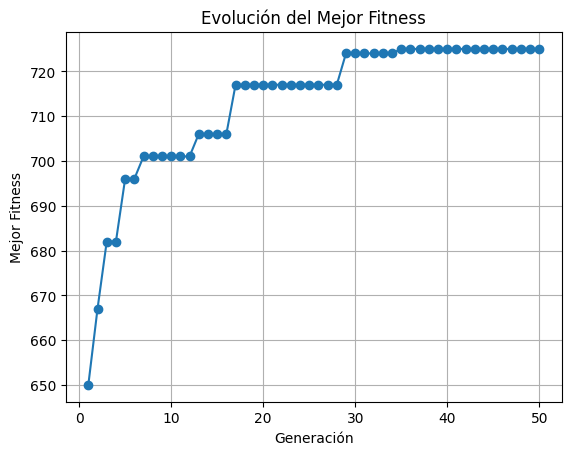

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Peso total: 112


In [ ]:
# Variando:
n = 20
pop_size = 500
num_generations = 50

# Manteniendo:
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán
penalty_factor = 0.5  # Factor de penalización para la restricción de peso

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


In [ ]:
n = 20  # Número de objetos de la mochila
pop_size = 200
num_generations = 20

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


NameError: name 'np' is not defined

In [ ]:
n = 20  # Número de objetos de la mochila
pop_size = 300
num_generations = 30

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)

NameError: name 'np' is not defined

In [ ]:
n = 200 # Número de objetos de la mochila
pop_size = 500
num_generations = 50

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


## Probando el código 2

Ahora cambiemos la función de penalización por la que hace uso del factor de penalización.

Para esto modificamos un poco la función principal:

In [ ]:
def genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor):
  # Generar la instancia del problema
  weights, benefits, capacity = knapsack_instances(n, w_range, b_range, alpha)

  print("Pesos:", weights)
  print("Beneficios:", benefits)
  print("Capacidad:", capacity)

  # Generar población inicial
  population = generate_initial_population(pop_size, n)

  # Inicializar incumbente
  incumbent = {'individual': None, 'fitness': -np.inf}
  fitness_history = []

  # Iterar a través de las generaciones
  for generation in range(num_generations):
    # Evaluar fitness de la población con penalización
    #fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])  #
    fitness = np.array([fitness_knapsack_penalized(ind, benefits, weights, capacity, penalty_factor) for ind in population])

    # Actualiza el incumbente
    incumbent = update_incumbent(incumbent, population, fitness)
    fitness_history.append(incumbent['fitness'])
    #print(f"Generación {generation + 1}: Mejor fitness = {incumbent['fitness']}")

    # Selección por ruleta
    parents = roulette_wheel_selection(population, fitness, pop_size)  # ojo num parents

    # Cruzamiento con porcentaje de cruzamiento
    children = crossover_population(parents, crossover_rate)

    # Mutación con tasa de mutación
    population = mutate_population(children, mutation_rate)

  # Evaluar fitness final y encontrar la mejor solución
  final_fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])
  #final_fitness = np.array([fitness_knapsack_penalized(ind, benefits, weights, capacity, penalty_factor) for ind in population])
  incumbent = update_incumbent(incumbent, population, final_fitness)
  # Graficar el progreso del mejor fitness
  plt.plot(range(1, num_generations + 1), fitness_history, marker='o', linestyle='-')
  plt.title('Evolución del Mejor Fitness')
  plt.xlabel('Generación')
  plt.ylabel('Mejor Fitness')
  plt.grid(True)
  plt.show()

  best_solution = incumbent['individual']
  best_fitness = incumbent['fitness']

  # Calcular el beneficio y peso total del mejor individuo
  total_benefit = np.sum(best_solution * benefits)
  total_weight = np.sum(best_solution * weights)

  return best_solution, best_fitness, total_benefit, total_weight


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


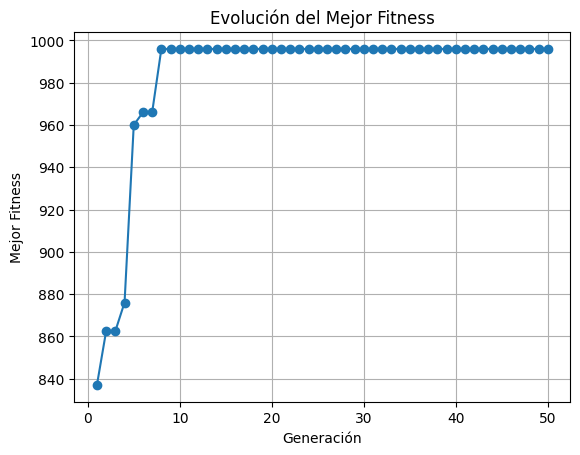

Último incumbente (champion):
Solución: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valor de fitness: 996.0
Beneficio total: 1052
Peso total: 224


In [ ]:
penalty_factor = 0.5  # Factor de penalización para la restricción de peso

n = 20
pop_size = 500
num_generations = 50

w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Terrible

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


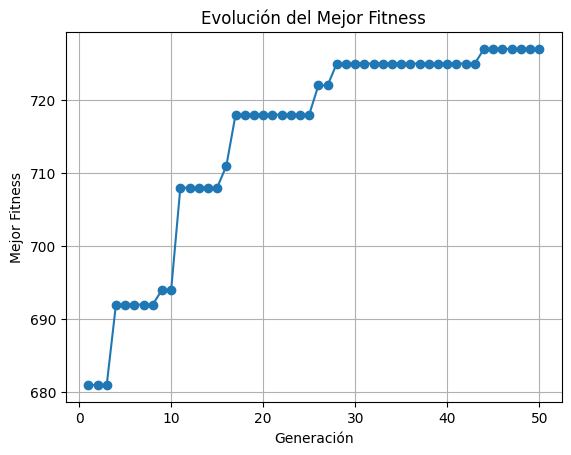

Último incumbente (champion):
Solución: [0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0]
Valor de fitness: 727
Beneficio total: 734
Peso total: 113


In [ ]:
penalty_factor = 7  # Factor de penalización para la restricción de peso SUPER ALTO

n = 20
pop_size = 500
num_generations = 50
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Se observa que hay que incrementar demasiado el factor de penalización para que entregue resultados factibles, por lo cual se concluye que la penalización reducida no es buena para este problema.

## Probando el código 3

Ahora vamos a jugar con otros parámetros como lo son el crossover_rate y mutation_rate.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


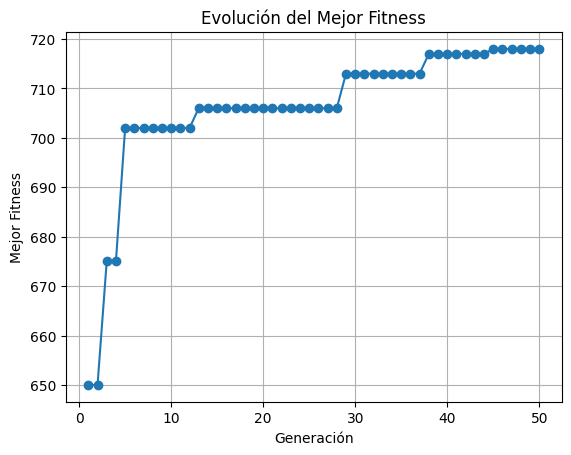

Último incumbente (champion):
Solución: [0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0]
Valor de fitness: 718
Beneficio total: 718
Peso total: 109


In [ ]:
# Variando:
crossover_rate = 0.4
mutation_rate = 0.02

# Manteniendo:
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
n = 20
pop_size = 500
num_generations = 50
penalty_factor = 0.5

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Disminuyendo por la mitad el crossover_rate se obtienen resultados bastante similares a ejecuciones anteriores, lo cual lleva a considerar que este parámetro en realidad no pesa tanto al momento de dar una solución.

*Mi tesis personal en este momento es que se debe al método de selección de ruleta, pues este puede llegar a ser un poco elitista. Si es cierto o no se sabrá más adelante cuando se experimente con otros métodos de selección*

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


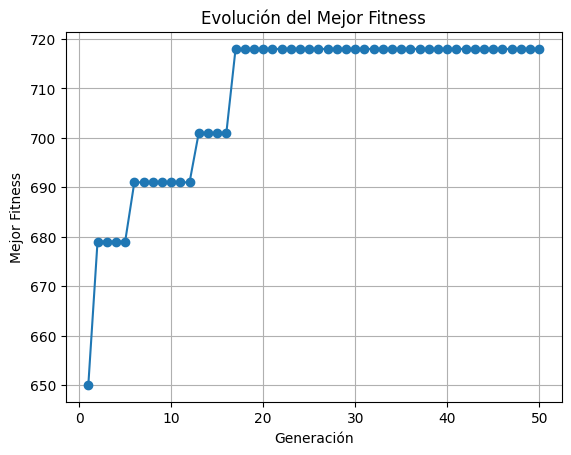

Último incumbente (champion):
Solución: [1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0]
Valor de fitness: 718
Beneficio total: 718
Peso total: 110


In [ ]:
# Variando:
crossover_rate = 0.4
mutation_rate = 0.05

# Manteniendo:
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
n = 20
pop_size = 500
num_generations = 50

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


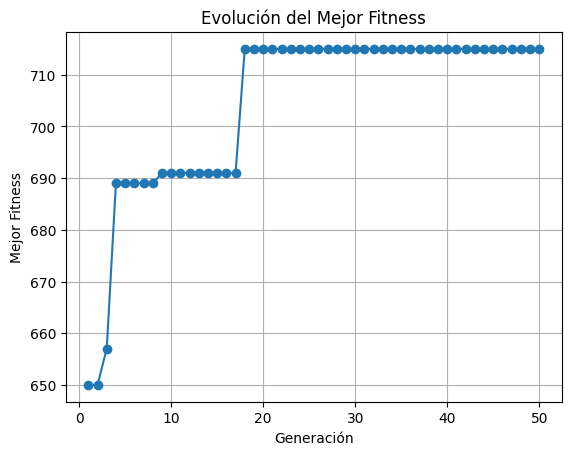

Último incumbente (champion):
Solución: [0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0]
Valor de fitness: 715
Beneficio total: 715
Peso total: 111


In [ ]:
# Variando:
crossover_rate = 0.4
mutation_rate = 0.5

# Manteniendo:
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
n = 20
pop_size = 500
num_generations = 50

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


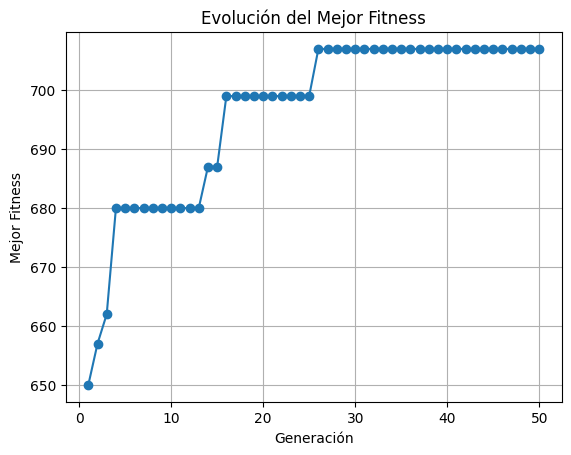

Último incumbente (champion):
Solución: [0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1]
Valor de fitness: 707
Beneficio total: 707
Peso total: 111


In [ ]:
# Variando:
crossover_rate = 0.4
mutation_rate = 0.8

# Manteniendo:
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
n = 20
pop_size = 500
num_generations = 50

np.random.seed(30)  # Semilla para reproducibilidad

best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, penalty_factor)

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Peso total:", total_weight)


Finalmente, al igual que el crossover_rate se observa que al modificar de manera considerable el mutation_rate no se presenta mayor cambio en los resultados.

# Implementación del experimento propuesto

*(punto dos de la entrega)*

A continuación se procederá a experimentar según las instancias establecidas por el profesor, variando no solo tamaño de la población inicial sino también parámetros como tasa de mutación, método de selección e incluso variación entre penalización y reparación.

## Función de reparación

Para llevar a cabo la tarea, lógicamente debemos definir funciones faltantes como esta.

La idea de la rearación es determinar qué individuos son infactibles a partir de una restricción para así modificar los genes del cromosoma hasta que este deje de ser infactible.

A diferencia de la penalización que cambia el fitness pero sin llegar a modificar al individuo, esta técnica puede llegar a afectar la diversidad de la población.

In [ ]:
def repair(chromosome, weights, capacity):
  total_weight = chromosome.dot(weights)

  # Reparar si el peso total excede la capacidad
  while total_weight > capacity:
    # Buscar un elemento que esté en la mochila y sacarlo
    index_to_remove = np.random.choice(np.where(chromosome == 1)[0])
    chromosome[index_to_remove] = 0
    total_weight = chromosome.dot(weights)

  return chromosome


## Selección por torneo

Es una alternativa a la selección por ruleta y otros métodos de selección, y tiene la ventaja de ser sencilla de implementar y ajustar.

Consiste en tomar aleatoriamente un subconjunto de la población de tamaño tournament_size a partir del cual se tomará al mejor individuo basado en su fitness y se seleccionará para ser padre. Esto se repite por cada padre solicitado.

El parámetro más influyente de esta selección es el tamaño del torneo pues, un torneo de gran tamaño, nos llevaría a soluciones rápidas mientras que torneos pqueños nos llevarían a soluciones más diversas.

In [ ]:
def tournament_selection(population, fitness, num_parents, tournament_size=3):
  parents = []
  for _ in range(num_parents):
    # Seleccionar el subgrupo
    tournament = random.sample(list(zip(population, fitness)), tournament_size)

    # Seleccionar el mejor individuo del torneo
    winner = max(tournament, key=lambda x: x[1])  # Selecciona por el fitness
    parents.append(winner[0])  # Pasa al individuo

  return parents


## Ajuste a la función principal

Finalmente, para empezar el experimento vamos a modificar un poco la función principal para que reciba como parámetro, tanto el método de selección como si se usará penalización o rearación.

In [ ]:
def genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection_type, penalty_or_repair):
  # Generar la instancia del problema
  weights, benefits, capacity = knapsack_instances(n, w_range, b_range, alpha)

  print("Pesos:", weights)
  print("Beneficios:", benefits)
  print("Capacidad:", capacity)

  # Generar población inicial
  population = generate_initial_population(pop_size, n)

  # Inicializar incumbente
  incumbent = {'individual': None, 'fitness': -np.inf}

  # Lista para guardar los mejores fitness por generación
  fitness_history = []

  # Iterar a través de las generaciones
  for generation in range(num_generations):

    # Manejo de restricciones según el método seleccionado
    if penalty_or_repair == "penalty":
      fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])
    elif penalty_or_repair == "repair":
      population = [repair(ind, weights, capacity) for ind in population]
      fitness = np.array(population).dot(benefits)
    else:
      print("Hubo error eligiendo entre penalización y reparación.")
      return

    # Actualiza el incumbente
    incumbent = update_incumbent(incumbent, population, fitness)
    fitness_history.append(incumbent['fitness'])
    #print(f"Generación {generation + 1}: Mejor fitness = {incumbent['fitness']}")

    # Selección de padres basada en el tipo de selección
    if selection_type == "roulette":
        parents = roulette_wheel_selection(population, fitness, pop_size)
    elif selection_type == "tournament":
        parents = tournament_selection(population, fitness, pop_size)

    # Cruzamiento con porcentaje de cruzamiento
    children = crossover_population(parents, crossover_rate)

    # Mutación con tasa de mutación
    population = mutate_population(children, mutation_rate)

  # Evaluar fitness final y encontrar la mejor solución
  final_fitness = np.array([fitness_knapsack_doomed(ind, benefits, weights, capacity) for ind in population])
  incumbent = update_incumbent(incumbent, population, final_fitness)
  # Graficar el progreso del mejor fitness
  plt.plot(range(1, num_generations + 1), fitness_history, marker='o', linestyle='-')
  plt.title('Evolución del Mejor Fitness')
  plt.xlabel('Generación')
  plt.ylabel('Mejor Fitness')
  plt.grid(True)
  plt.show()

  best_solution = incumbent['individual']
  best_fitness = incumbent['fitness']

  # Calcular el beneficio y peso total del mejor individuo
  total_benefit = np.sum(best_solution * benefits)
  total_weight = np.sum(best_solution * weights)

  return best_solution, best_fitness, total_benefit, total_weight


## Primera instancia

Vamos a probarla tanto con selección de ruleta como con selección de torneo con dejando los otros paámetros constantes.

Además vamos a empezar a registar el tiempo exacto de ejecución usando la librería time de python y vamos a ir guardando estos tiempos para una comparación al final.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


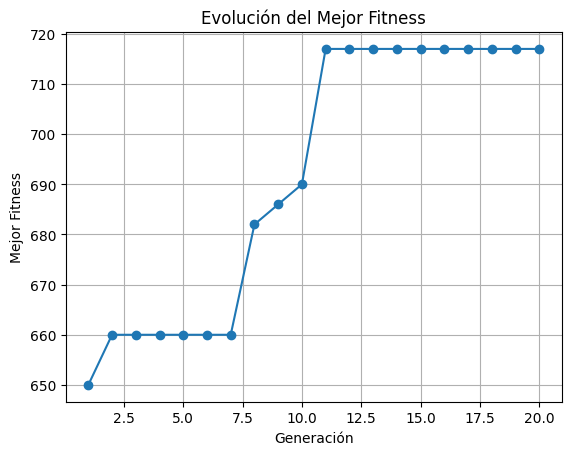

Último incumbente (champion):
Solución: [1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0]
Valor de fitness: 717
Beneficio total: 717
Selección: ruleta
Penalización: no
Reparación: sí.
Peso total: 109
Tiempo de ejecución: 0.45 segundos


In [ ]:
import time


roulette_times = []
tournament_times = []

# Variando:
pop_size = 200  # Tamaño de la población solicitada
num_generations = 20
selection = "roulette"
penalty_or_repair = "repair"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: no")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
roulette_times.append(execution_time)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


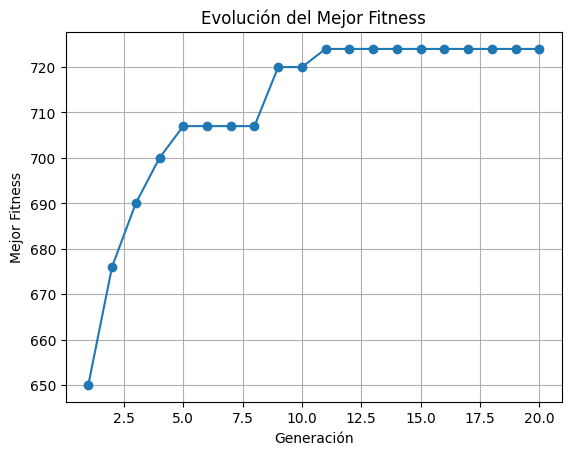

Último incumbente (champion):
Solución: [0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 724
Beneficio total: 724
Selección: torneo
Penalización: no
Reparación: sí.
Peso total: 111
Tiempo de ejecución: 0.47 segundos


In [ ]:
# Variando:
pop_size = 200  # Tamaño de la población solicitada
num_generations = 20
selection = "tournament"
penalty_or_repair = "repair"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: no")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
tournament_times.append(execution_time)


## Segunda instancia

Misma población pero por penalización, seguimos variando entre ruleta y torneo.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


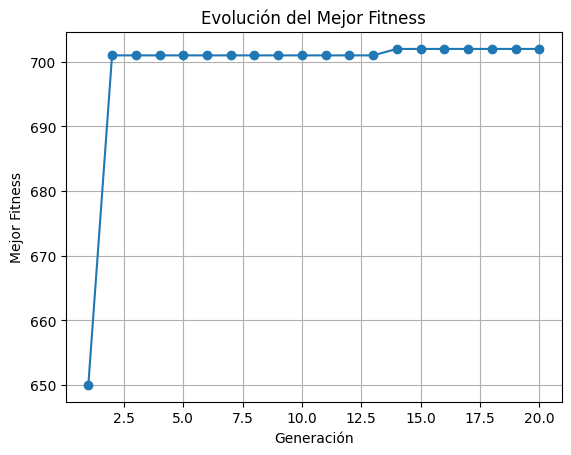

Último incumbente (champion):
Solución: [0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 702
Beneficio total: 702
Selección: ruleta
Penalización: sí
Reparación: no.
Peso total: 108
Tiempo de ejecución: 0.46 segundos


In [ ]:
# Variando:
pop_size = 200  # Tamaño de la población solicitada
num_generations = 20
selection = "roulette"
penalty_or_repair = "penalty"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: sí")
print("Reparación: no.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


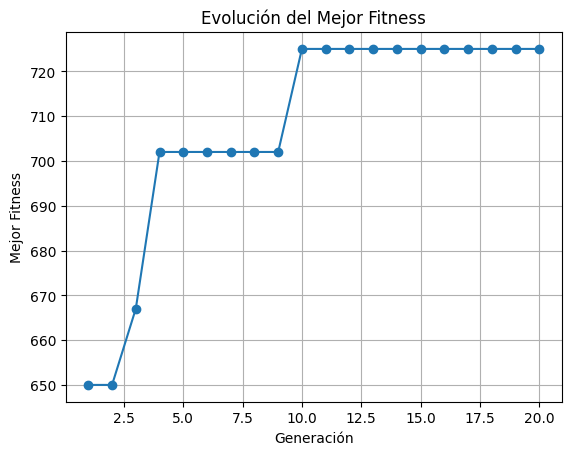

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: torneo
Penalización: sí
Reparación: no.
Peso total: 112
Tiempo de ejecución: 0.58 segundos


In [ ]:
# Variando:
pop_size = 200  # Tamaño de la población solicitada
num_generations = 20
selection = "tournament"
penalty_or_repair = "penalty"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: sí")
print("Reparación: no.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")


## Tercera instancia

Población inicial de 500 por reparación.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


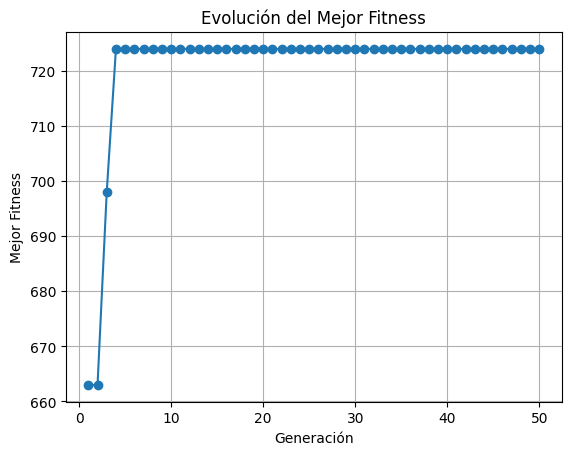

Último incumbente (champion):
Solución: [0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 724
Beneficio total: 724
Selección: ruleta
Penalización: no
Reparación: sí.
Peso total: 111
Tiempo de ejecución: 1.53 segundos


In [ ]:
# Variando:
pop_size = 500  # Tamaño de la población solicitada
num_generations = 50
selection = "roulette"
penalty_or_repair = "repair"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: no")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
roulette_times.append(execution_time)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


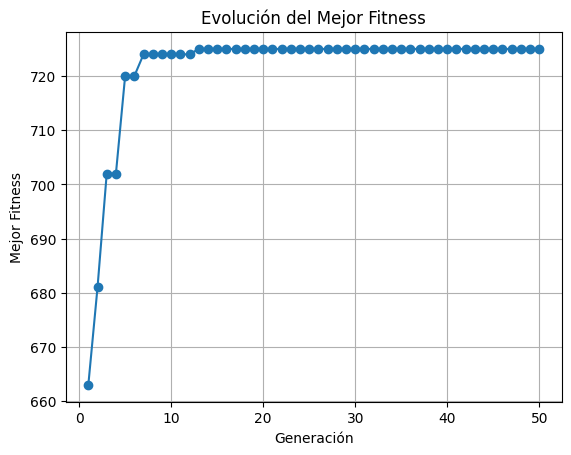

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: torneo
Penalización: no
Reparación: sí.
Peso total: 112
Tiempo de ejecución: 2.28 segundos


In [ ]:
# Variando:
pop_size = 500  # Tamaño de la población solicitada
num_generations = 50
selection = "tournament"
penalty_or_repair = "repair"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: no")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
tournament_times.append(execution_time)


## Cuarta instancia

Población inicial de 500 por penalización.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


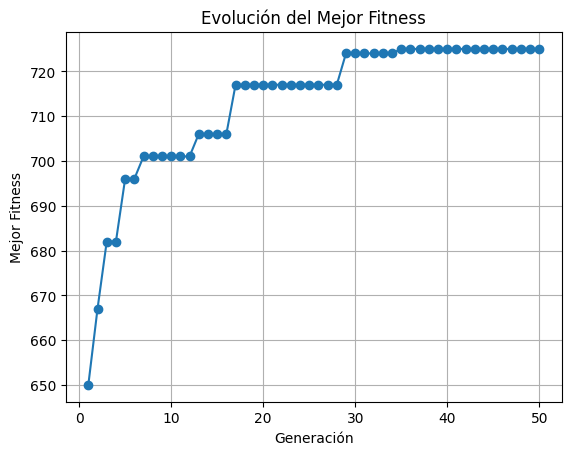

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: ruleta
Penalización: sí
Reparación: no.
Peso total: 112
Tiempo de ejecución: 1.62 segundos


In [ ]:
# Variando:
pop_size = 500  # Tamaño de la población solicitada
num_generations = 50
selection = "roulette"
penalty_or_repair = "penalty"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: sí")
print("Reparación: no.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


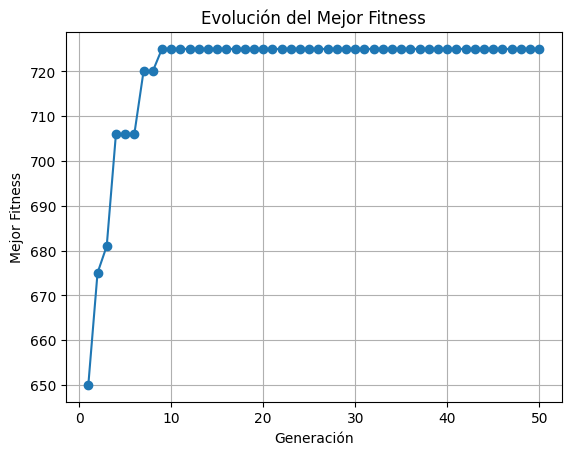

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: torneo
Penalización: sí
Reparación: no.
Peso total: 112
Tiempo de ejecución: 5.51 segundos


In [ ]:
# Variando:
pop_size = 500  # Tamaño de la población solicitada
num_generations = 50
selection = "tournament"
penalty_or_repair = "penalty"

# Manteniendo:
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: sí")
print("Reparación: no.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")


## Quinta instancia

Población inicial 750, Lo intentamos con ambos tipos de selección.

*Personalmente elijo reparación porque es el que menos he trabajado y he notado que no converge tan rápido en una solución.*

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


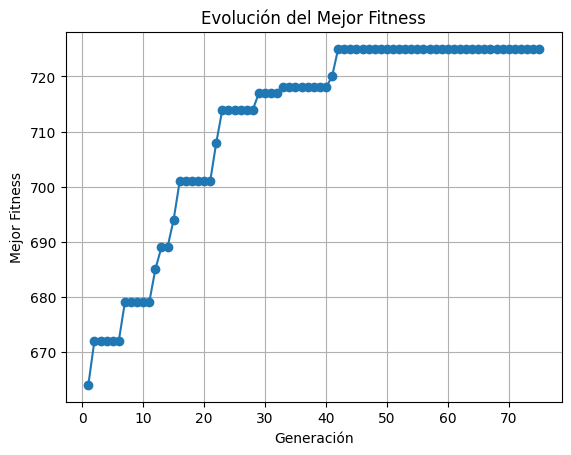

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: ruleta
Penalización: non
Reparación: sí.
Peso total: 112
Tiempo de ejecución: 3.17 segundos


In [ ]:
# Variando:
pop_size = 750  # Tamaño de la población solicitada
num_generations = 75
selection = "roulette"

# Manteniendo:
penalty_or_repair = "repair"
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: non")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
roulette_times.append(execution_time)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


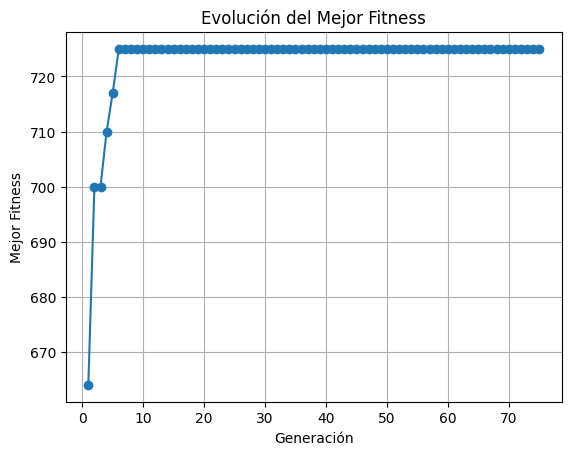

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: torneo
Penalización: non
Reparación: sí.
Peso total: 112
Tiempo de ejecución: 6.28 segundos


In [ ]:
# Variando:
pop_size = 750  # Tamaño de la población solicitada
num_generations = 75
selection = "tournament"

# Manteniendo:
penalty_or_repair = "repair"
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: non")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
tournament_times.append(execution_time)


## Sexta instancia

Población inicial de 1000, así como en el anterior lo ejecutamos por reparación con ambos métodos de seleción.

Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


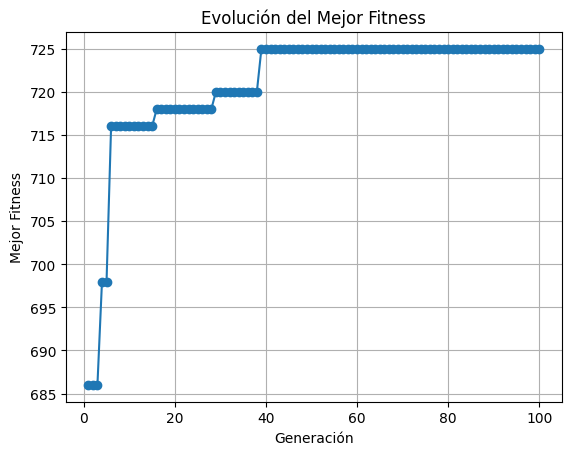

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: ruleta
Penalización: non
Reparación: sí.
Peso total: 112
Tiempo de ejecución: 6.73 segundos


In [ ]:
# Variando:
pop_size = 1000  # Tamaño de la población solicitada
num_generations = 100
selection = "roulette"

# Manteniendo:
penalty_or_repair = "repair"
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: ruleta")
print("Penalización: non")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
roulette_times.append(execution_time)


Pesos: [ 6  6 14 14 13  3 18 15  4 10  8  2 18 14  4 19 19  7 13 17]
Beneficios: [16 72 37 56 55 74 72 21 25 33 23 60 43 65 38 68 88 67 85 54]
Capacidad: 112


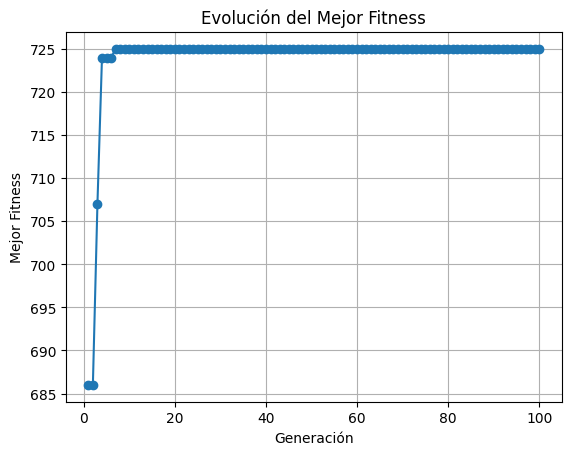

Último incumbente (champion):
Solución: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0]
Valor de fitness: 725
Beneficio total: 725
Selección: torneo
Penalización: non
Reparación: sí.
Peso total: 112
Tiempo de ejecución: 12.34 segundos
[0.47098255157470703, 2.2840733528137207, 6.280618906021118, 12.341004848480225]


In [ ]:
# Variando:
pop_size = 1000  # Tamaño de la población solicitada
num_generations = 100
selection = "tournament"

# Manteniendo:
penalty_or_repair = "repair"
n = 20
w_range = (1, 20)
b_range = (10, 100)
alpha = 0.5
crossover_rate = 0.8  # 80% de los padres seleccionados se cruzarán
mutation_rate = 0.02  # 2% de los genes mutarán

np.random.seed(30)  # Semilla para reproducibilidad

star_time = time.time()

# Ejecutar con selección por ruleta y penalización
best_solution, best_fitness, total_benefit, total_weight = genetic_algorithm_knapsack(n, w_range, b_range, alpha, pop_size, num_generations, crossover_rate, mutation_rate, selection, penalty_or_repair)

execution_time = time.time() - star_time

print("Último incumbente (champion):")
print("Solución:", best_solution)
print("Valor de fitness:", best_fitness)
print("Beneficio total:", total_benefit)
print("Selección: torneo")
print("Penalización: non")
print("Reparación: sí.")
print("Peso total:", total_weight)
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
tournament_times.append(execution_time)


## Visualizando el experimento

Finalmente vamos a graficar la selección de la ruleta frente a la selección de torneo.

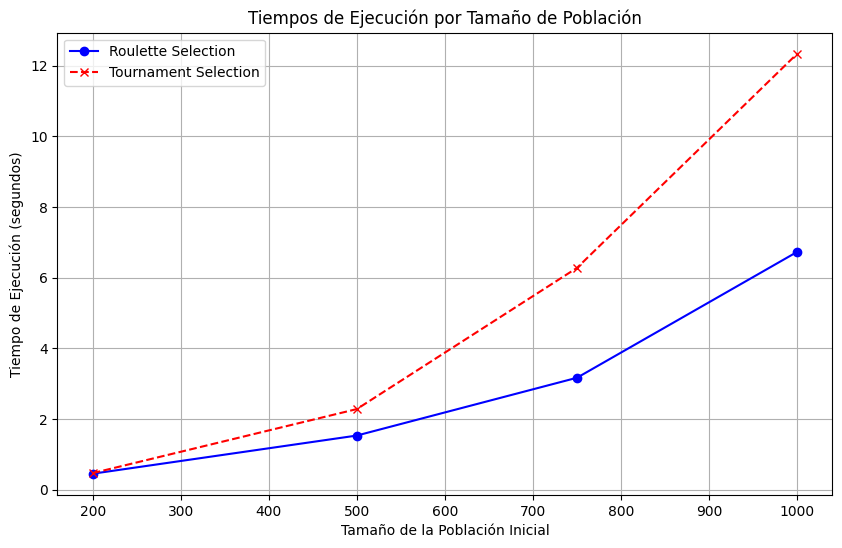

In [ ]:
# Graficar los tiempos de ejecución
pop_sizes = [200, 500, 750, 1000]

plt.figure(figsize=(10, 6))
plt.plot(pop_sizes, roulette_times, marker='o', linestyle='-', color='b', label='Roulette Selection')
plt.plot(pop_sizes, tournament_times, marker='x', linestyle='--', color='r', label='Tournament Selection')
plt.title('Tiempos de Ejecución por Tamaño de Población')
plt.xlabel('Tamaño de la Población Inicial')
plt.ylabel('Tiempo de Ejecución (segundos)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusiones

* Se evidenció como el cambio de algunos parámetros afecta en gran medida el resultado de las ejecuciones.
* A pesar de que el método de la ruleta arrojaba resultados más rápidamente, el método del torneo aporta más diversidad a la selección al estar establecido en un tamaño de torneo pequeño, por lo cual para otro tipo de instancias o problemas podría llegar a desempeñarse mejor.
* Se evidenció en algunos casos que la implementación de un criterio de parada más allá del de cumplir con ciertas generaciones hubiera sido útil, como por ejemplo que después de cierto número de generaciones sin cambio en el incumbente se termine la ejecución.